# |In this notebook we use a two stain SEIR model to forecast for future using predefined parameters

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [3]:
sns.set()
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from sir_models.seir_two_stain import SEIRTwoStain
from sir_models.utils import stepwise

# Load data

In [7]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

# Future forecast

In [10]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)[1:]
future_t = np.arange(len(future_dates))

assert len(future_dates) == len(future_t)

In [11]:
future_dates

DatetimeIndex(['2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-23', '2021-01-24',
               ...
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12',
               '2021-07-13', '2021-07-14'],
              dtype='datetime64[ns]', length=181, freq='D')

In [13]:
future_t

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [14]:
from lmfit import Parameters

In [15]:
params = Parameters()
params.add("base_population", value=12_000_000, vary=False)
params.add("pre_existing_immunity", value=0.1806, vary=False)
params.add("sus_population", expr='base_population - base_population * pre_existing_immunity', vary=False)
params.add("r0_1", value=3.55, vary=False)
params.add("new_stain_mult", value=1.5, vary=False)
params.add("r0_2", expr='r0_1 * new_stain_mult', vary=False)

params.add(f"t0_q", value=0.6, min=0, max=0.99, brute_step=0.1, vary=False)     

params.add("delta", value=1/5.15, vary=False) # E -> I rate
params.add("alpha", value=0.0066, min=0.0066, max=0.05, vary=False) # Probability to die if infected
params.add("gamma", value=1/3.5, vary=False) # I -> R rate
params.add("rho", value=1/14, vary=False) # I -> D rate

model = SEIRTwoStain(params=params)

In [16]:
df.iloc[-1]

date                     2021-01-14 00:00:00
total_infected                        877428
total_recovered                       722487
total_dead                             12241
deaths_per_day                            68
infected_per_day                        5893
recovered_per_day                       7049
infected                              142700
total_infected_ma7                    862538
total_recovered_ma7                   701744
total_dead_ma7                       12022.6
deaths_per_day_ma7                     73.29
infected_per_day_ma7                 4857.57
recovered_per_day_ma7                6970.71
infected_ma7                          148771
Name: 308, dtype: object

In [17]:
new_stain_ratio = 0.01

I1 = df.iloc[-1].infected - new_stain_ratio * df.iloc[-1].infected
I2 = new_stain_ratio * df.iloc[-1].infected

E1 = I1
E2 = I2

R = df.iloc[-1].total_recovered
D = df.iloc[-1].total_dead

S = params['sus_population'].value - I1 - I2 - E1 - E2 - R - D

initial_conditions = (S, E1, I1, E2, I2, R, D)
initial_conditions

(8812672.0, 141273.0, 141273.0, 1427.0, 1427.0, 722487, 12241)

In [18]:
(future_S, future_E1, future_I1, future_E2, future_I2, future_R, future_D), history = model._predict(future_t, initial_conditions)

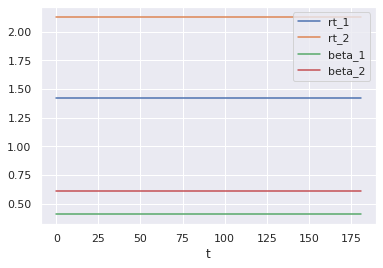

In [19]:
plt.figure()
history.rt_1.plot()
history.rt_2.plot()

history.beta_1.plot()
history.beta_2.plot()
plt.legend()
plt.show()

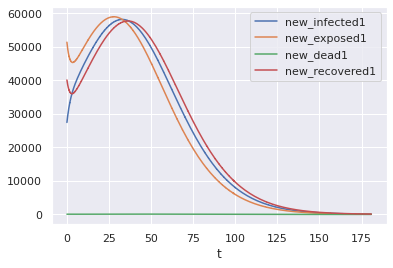

In [20]:
history.new_infected1.plot()
history.new_exposed1.plot()
history.new_dead1.plot()
history.new_recovered1.plot()
plt.legend()

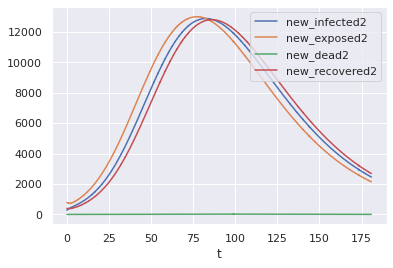

In [21]:
history.new_infected2.plot()
history.new_exposed2.plot()
history.new_dead2.plot()
history.new_recovered2.plot()
plt.legend()

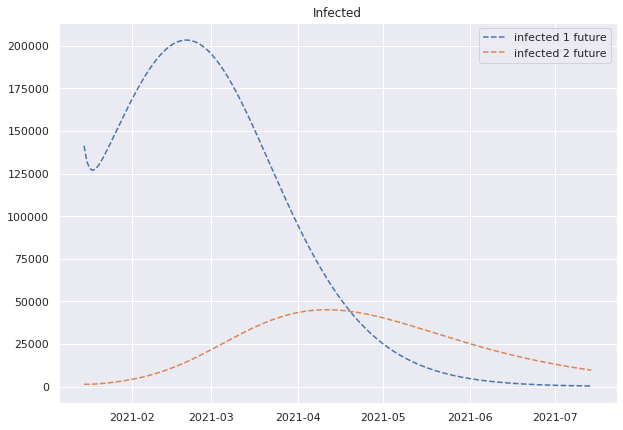

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1, label='infected 1 future', linestyle='--')
plt.plot(future_dates, future_I2, label='infected 2 future', linestyle='--')
plt.legend()
plt.title('Infected')
plt.show()

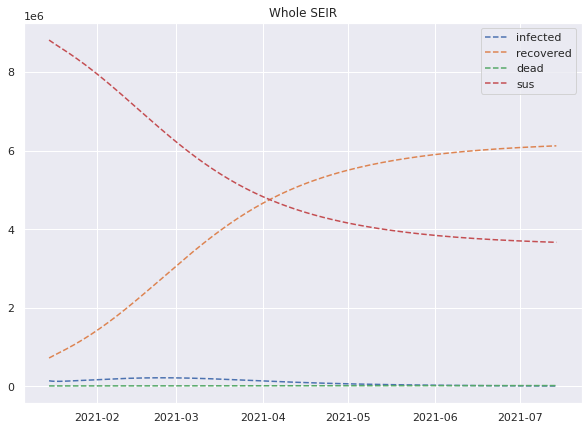

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1 + future_I2, label='infected', linestyle='--')
plt.plot(future_dates, future_R, label='recovered', linestyle='--')
plt.plot(future_dates, future_D, label='dead', linestyle='--')
plt.plot(future_dates, future_S, label='sus', linestyle='--')
plt.legend()
plt.title('Whole SEIR')
plt.show()